<a href="https://colab.research.google.com/github/TheCaveOfAdullam/FanalTest_motor_5.5kw_KdDpp/blob/main/FinalTest_TaylorOnly_5_5kw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=b505647b34c80fe0bdb61ef160e9fab87a9f5fa817b71af199a55f04dbc8f76a
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=72d16079cfacbfb7ed9fe811e348617c891cd1cf310101f19fca0b0b7ff4a1bd
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.utils.prune as prune
import torch_pruning as tp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import time
import random

In [4]:
seed = 72
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/motor_5.5kw_ver5'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 전처리 함수 정의
class VibrationDataset(Dataset):
    def __init__(self, base_dir, split, categories, label_encoder, segment_length=4000, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        self.segment_length = segment_length
        self.file_count = defaultdict(int)  # 카테고리별 파일 개수를 저장할 딕셔너리

        split_dir = os.path.join(base_dir, split)
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            files = os.listdir(category_dir)
            self.file_count[category] = len(files)  # 카테고리별 파일 수 저장

            for file in files:
                file_path = os.path.join(category_dir, file)
                data = pd.read_csv(file_path, header=None, skiprows=1)  # 첫 행 건너뜀

                # 첫 번째 열(시간 데이터)을 제외하고 주파수 데이터만 선택
                frequency_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

                # 데이터를 세그먼트로 분할
                num_segments = frequency_data.shape[0] // self.segment_length
                for i in range(num_segments):
                    segment = frequency_data[i * self.segment_length:(i + 1) * self.segment_length]
                    self.X.append(segment)  # 주파수 데이터만 포함
                    self.y.append(label_encoder.transform([category])[0])

        # 카테고리별 파일 개수 출력
        print(f"File count for '{split}' split:")
        for category, count in self.file_count.items():
            print(f"  {category}: {count} files")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T  # 2D 입력 (채널, 길이)로 변경
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# 레이블 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# 데이터셋 준비
train_dataset = VibrationDataset(base_dir, 'train', categories, label_encoder)
val_dataset = VibrationDataset(base_dir, 'validation', categories, label_encoder)
test_dataset = VibrationDataset(base_dir, 'test', categories, label_encoder)

# 데이터 로더
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

File count for 'train' split:
  normal: 2100 files
  fault_BB: 2100 files
  fault_RI: 2100 files
  fault_SM: 2100 files
File count for 'validation' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
File count for 'test' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
Input length for one sample: 4000


In [6]:
# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=16, stride=16)  # 입력 채널을 1로 수정
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 출력 크기 계산
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)  # 1은 입력 채널 수
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        self.fc1 = nn.Linear(conv_output_size, 5000)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flattening
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# 학습 및 검증 손실, 정확도 기록을 위한 train_model 함수 수정
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 학습 및 검증 손실, 정확도 기록용 리스트
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm을 사용하여 진행 상황을 표시
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 현재 배치의 손실과 정확도를 tqdm에 표시
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        # Training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation evaluation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)[:2]

        # 기록용 리스트에 추가
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# 학습 곡선 시각화 함수 (전체 학습 곡선 통합)
def plot_combined_learning_curves(total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies):
    epochs = range(1, len(total_train_losses) + 1)

    # 손실 곡선
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, total_train_losses, label='Train Loss')
    plt.plot(epochs, total_val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Combined Training and Validation Loss')
    plt.legend()

    # 정확도 곡선
    plt.subplot(1, 2, 2)
    plt.plot(epochs, total_train_accuracies, label='Train Accuracy')
    plt.plot(epochs, total_val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Combined Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [8]:
# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # 배치 손실의 합
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 평균 손실은 배치 개수로 나눔
    average_val_loss = val_loss / len(loader)  # len(loader)는 배치 개수
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

In [9]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB

    if model_size < 1:
        return model_size * 1024  # Convert to KB if size is less than 1MB
    return model_size

In [10]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [11]:
# 1. Taylor 기반 중요도 계산 후 마스크 적용 (마스크 방식)
def prune_by_taylor_with_mask(model, threshold=0.01):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            if module.weight.grad is None:
                raise ValueError(f"Gradients not found for {name}. Run backward pass before pruning.")

            # 중요도 계산
            importance = torch.abs(module.weight * module.weight.grad)
            mask = (importance >= threshold).float()  # 중요도에 따라 마스크 생성

            # 중복 프루닝 방지
            if hasattr(module, 'weight_mask'):
                prune.remove(module, 'weight')

            # 마스크 적용 방식으로 pruning
            prune.custom_from_mask(module, name='weight', mask=mask)

            # 로그 출력 (선택 사항)
            num_total = module.weight.numel()
            num_pruned = (mask == 0).sum().item()
            print(f"{name}: Pruned {num_pruned}/{num_total} weights ({100 * num_pruned / num_total:.2f}%)")
    print(f"Taylor-based pruning with mask applied (threshold={threshold})")


In [12]:
# 2. 전체 파이프라인 함수
def prune_and_retrain_taylor_with_mask(model, train_loader, val_loader, test_loader,
                                       criterion, device, optimizer_params, threshold_taylor=0.01):
    # 옵티마이저 초기화
    optimizer = optim.Adam(model.parameters(), **optimizer_params)

    # Step 0: 초기 훈련
    print("Initial training before Taylor pruning (with mask)")
    init_train_losses, init_val_losses, init_train_accuracies, init_val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=4
    )

    # Step 1: Taylor 전개 기반 프루닝 - 마스크 방식
    print("Step 1: Taylor-based unstructured pruning (with mask)")
    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    # 마스크 적용
    prune_by_taylor_with_mask(model, threshold=threshold_taylor)

    # Step 2: 재학습
    optimizer = optim.Adam(model.parameters(), **optimizer_params)
    print("Retraining after Taylor pruning (with mask)")
    retrain_train_losses, retrain_val_losses, retrain_train_accuracies, retrain_val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=11
    )

    # 전체 학습 곡선 통합
    total_train_losses = init_train_losses + retrain_train_losses
    total_val_losses = init_val_losses + retrain_val_losses
    total_train_accuracies = init_train_accuracies + retrain_train_accuracies
    total_val_accuracies = init_val_accuracies + retrain_val_accuracies

    # 시각화
    plot_combined_learning_curves(total_train_losses, total_val_losses,
                                   total_train_accuracies, total_val_accuracies)

    # Step 3: 테스트셋 평가
    print("Final evaluation on test set (after masked Taylor pruning)...")
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)[:2]
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

    return model

    # 3. 저장 시 마스크 제거하고 실제 weight에 반영 (선택)
def remove_pruning_masks(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            if hasattr(module, 'weight_mask'):
                prune.remove(module, 'weight')
    print("Pruning masks removed and weights made permanent.")

In [13]:
# 파라미터 설정 및 프루닝 실행
model = CNNModel(input_length=input_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_params = {'lr': 0.00001, 'weight_decay': 1e-5}

In [14]:
model_size = get_model_size(model)

if model_size < 1:
    print(f'Model size: {model_size * 1024:.2f} KB')
else:
    print(f'Model size: {model_size:.2f} MB')

Model size: 158.50 MB


In [15]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 41548655
Total number of weights: 41548660
Percentage of non-zero weights: 100.00%


Initial training before Taylor pruning (with mask)


Epoch 1/4: 100%|██████████| 788/788 [00:21<00:00, 36.64batch/s, accuracy=56.6, loss=0.458]


Epoch [1/4], Loss: 1.1554, Accuracy: 56.61%, Val Loss: 0.6720, Val Accuracy: 74.41%


Epoch 2/4: 100%|██████████| 788/788 [00:19<00:00, 39.92batch/s, accuracy=93, loss=0.228]


Epoch [2/4], Loss: 0.3074, Accuracy: 93.01%, Val Loss: 0.4457, Val Accuracy: 80.43%


Epoch 3/4: 100%|██████████| 788/788 [00:19<00:00, 39.88batch/s, accuracy=95.2, loss=0.146]


Epoch [3/4], Loss: 0.1521, Accuracy: 95.16%, Val Loss: 0.4382, Val Accuracy: 82.11%


Epoch 4/4: 100%|██████████| 788/788 [00:19<00:00, 39.65batch/s, accuracy=96.1, loss=0.0438]


Epoch [4/4], Loss: 0.1159, Accuracy: 96.12%, Val Loss: 0.3199, Val Accuracy: 86.78%
Step 1: Taylor-based unstructured pruning (with mask)
conv1: Pruned 302/1024 weights (29.49%)
conv2: Pruned 2524/6144 weights (41.08%)
conv3: Pruned 4418/10240 weights (43.14%)
conv4: Pruned 24200/40960 weights (59.08%)
fc1: Pruned 36470660/36480000 weights (99.97%)
fc2: Pruned 4804429/5000000 weights (96.09%)
fc3: Pruned 2090/4000 weights (52.25%)
Taylor-based pruning with mask applied (threshold=4e-06)
Retraining after Taylor pruning (with mask)


Epoch 1/11: 100%|██████████| 788/788 [00:23<00:00, 33.53batch/s, accuracy=40.4, loss=1.31]


Epoch [1/11], Loss: 1.3616, Accuracy: 40.44%, Val Loss: 1.3000, Val Accuracy: 65.78%


Epoch 2/11: 100%|██████████| 788/788 [00:23<00:00, 33.29batch/s, accuracy=59.7, loss=1.03]


Epoch [2/11], Loss: 1.1545, Accuracy: 59.74%, Val Loss: 0.9732, Val Accuracy: 50.59%


Epoch 3/11: 100%|██████████| 788/788 [00:23<00:00, 33.70batch/s, accuracy=70.7, loss=0.763]


Epoch [3/11], Loss: 0.8200, Accuracy: 70.67%, Val Loss: 0.7221, Val Accuracy: 71.02%


Epoch 4/11: 100%|██████████| 788/788 [00:23<00:00, 33.76batch/s, accuracy=86.9, loss=0.326]


Epoch [4/11], Loss: 0.5629, Accuracy: 86.89%, Val Loss: 0.5742, Val Accuracy: 77.33%


Epoch 5/11: 100%|██████████| 788/788 [00:23<00:00, 33.74batch/s, accuracy=93.4, loss=0.293]


Epoch [5/11], Loss: 0.3670, Accuracy: 93.39%, Val Loss: 0.4698, Val Accuracy: 77.87%


Epoch 6/11: 100%|██████████| 788/788 [00:23<00:00, 33.67batch/s, accuracy=94.3, loss=0.12]


Epoch [6/11], Loss: 0.2539, Accuracy: 94.29%, Val Loss: 0.3915, Val Accuracy: 81.44%


Epoch 7/11: 100%|██████████| 788/788 [00:23<00:00, 33.64batch/s, accuracy=94.4, loss=0.159]


Epoch [7/11], Loss: 0.1999, Accuracy: 94.43%, Val Loss: 0.3821, Val Accuracy: 80.57%


Epoch 8/11: 100%|██████████| 788/788 [00:23<00:00, 33.64batch/s, accuracy=94.7, loss=0.0985]


Epoch [8/11], Loss: 0.1678, Accuracy: 94.71%, Val Loss: 0.3408, Val Accuracy: 84.31%


Epoch 9/11: 100%|██████████| 788/788 [00:23<00:00, 33.72batch/s, accuracy=95.2, loss=0.167]


Epoch [9/11], Loss: 0.1475, Accuracy: 95.24%, Val Loss: 0.3537, Val Accuracy: 84.56%


Epoch 10/11: 100%|██████████| 788/788 [00:23<00:00, 33.83batch/s, accuracy=95.8, loss=0.128]


Epoch [10/11], Loss: 0.1313, Accuracy: 95.83%, Val Loss: 0.3049, Val Accuracy: 86.67%


Epoch 11/11: 100%|██████████| 788/788 [00:23<00:00, 33.74batch/s, accuracy=96.3, loss=0.262]


Epoch [11/11], Loss: 0.1182, Accuracy: 96.30%, Val Loss: 0.3342, Val Accuracy: 86.00%


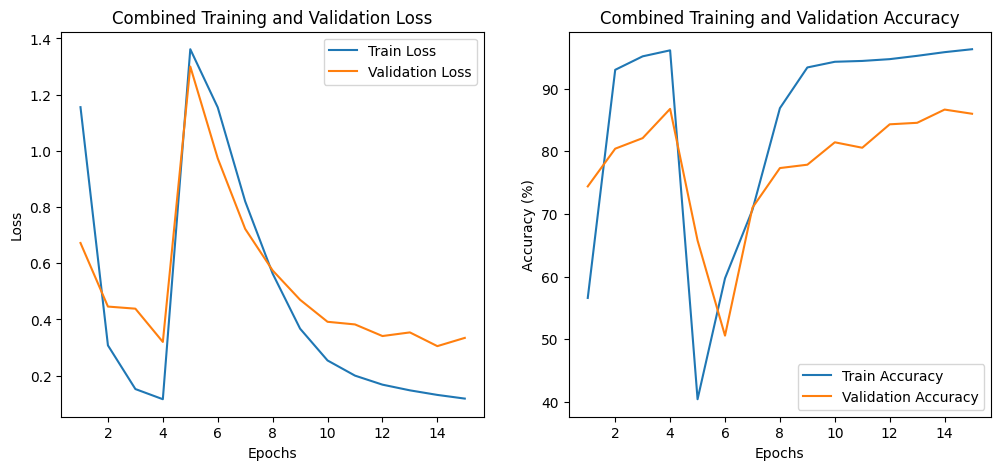

Final evaluation on test set (after masked Taylor pruning)...
Final Test Loss: 0.2775, Final Test Accuracy: 88.46%


In [16]:
model = prune_and_retrain_taylor_with_mask(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    device,
    optimizer_params,
    threshold_taylor=4e-6
)

In [17]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.2775, Final Test Accuracy: 88.46%


In [18]:
model_size = get_model_size(model)

if model_size < 1:
    print(f'Model size: {model_size * 1024:.2f} KB')
else:
    print(f'Model size: {model_size:.2f} MB')

Model size: 316.97 MB


In [19]:
# 저장 전에 마스크 제거 (선택 사항)
remove_pruning_masks(model)
torch.save(model.state_dict(), 'pruned_model.pth')

Pruning masks removed and weights made permanent.


In [20]:
# 파일 크기 확인
file_size = os.path.getsize("pruned_model.pth") / 1024**2  # MB로 변환
print(f"모델 크기: {file_size:.2f} MB")

모델 크기: 158.50 MB


In [21]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 240037
Total number of weights: 41548660
Percentage of non-zero weights: 0.58%


In [22]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            zero_params += torch.sum(param == 0).item()
    sparsity = 100.0 * zero_params / total_params
    print(f"Model Sparsity: {sparsity:.2f}% ({zero_params} / {total_params} weights are zero)")
    return sparsity

In [23]:
calculate_sparsity(model)

Model Sparsity: 99.42% (41308623 / 41548660 weights are zero)


99.42227499033663

In [24]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total
    return val_loss / total, accuracy, conf_matrix

Test Loss: 0.0087
Test Accuracy: 88.46%
Confusion Matrix:
[[ 909  437    4    0]
 [   0 1350    0    0]
 [ 131    0 1213    6]
 [   0    0   45 1305]]


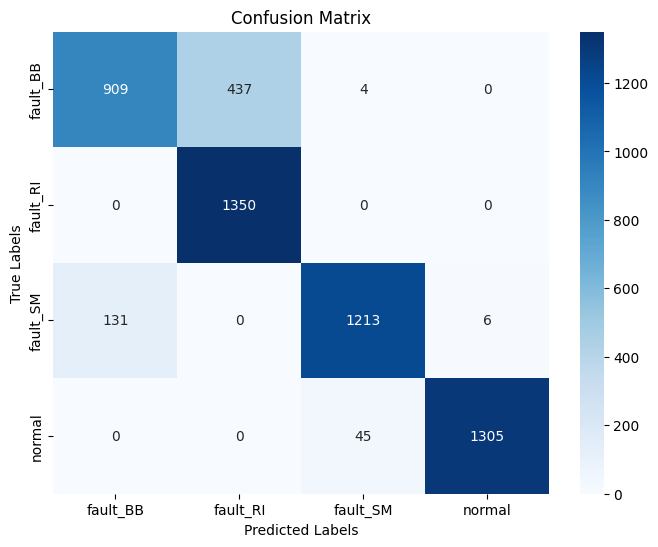

In [25]:
# 혼동 행렬 시각화 함수
def plot_confusion_matrix(conf_matrix, label_encoder):
    categories = label_encoder.classes_  # LabelEncoder의 순서대로 클래스 레이블을 가져옴
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 테스트 데이터 평가
test_loss, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, criterion)

# 결과 출력
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(test_conf_matrix)

# 혼동 행렬 시각화
plot_confusion_matrix(test_conf_matrix, label_encoder)

In [26]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 48.42 MFLOPs
| module         | #parameters or shape   | #flops   |
|:---------------|:-----------------------|:---------|
| model          | 41.549M                | 48.425M  |
|  conv1         |  1.088K                |  0.256M  |
|   conv1.bias   |   (64,)                |          |
|   conv1.weight |   (64, 1, 16)          |          |
|  conv2         |  6.176K                |  0.756M  |
|   conv2.bias   |   (32,)                |          |
|   conv2.weight |   (32, 64, 3)          |          |
|  conv3         |  10.304K               |  1.219M  |
|   conv3.bias   |   (64,)                |          |
|   conv3.weight |   (64, 32, 5)          |          |
|  conv4         |  41.088K               |  4.71M   |
|   conv4.bias   |   (128,)               |          |
|   conv4.weight |   (128, 64, 5)         |          |
|  fc1           |  36.485M               |  36.48M  |
|   fc1.bias     |   (5000,)              |          |
|   fc1.weight   |   (5000, 7296)      

In [27]:
print("\nCalculating F1 Score...")
calculate_f1_score(model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.8827


In [28]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [29]:
print("\nCalculating Total Parameters...")
calculate_total_params(model)


Calculating Total Parameters...
Total Parameters: 41,548,660


In [30]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [31]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [32]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu, weights_only=False)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.
Model loaded and moved to CPU.


In [33]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [124]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)


Measuring Inference Time on CPU...
Average Inference Time: 18.37 ms


0.018370976448059084